In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
import os
from collections import Counter


# Word-level Metaphor Annotation 

In [2]:
USE_TAGGED_DATA = True

In [3]:
# load in metaphor detection model
tokenizer = AutoTokenizer.from_pretrained("lwachowiak/Metaphor-Detection-XLMR")
label_list = ['literal', "metaphoric"]
label_dict_relations = {i: l for i, l in enumerate(label_list)}
model = AutoModelForTokenClassification.from_pretrained(
    "lwachowiak/Metaphor-Detection-XLMR", id2label=label_dict_relations)
pipeline_metaphors = pipeline("ner", model=model, tokenizer=tokenizer)


In [4]:
# this step relies on having sentences from a corpus already categorized by seed words and saved in a folder called "filtered_sentences"
if not USE_TAGGED_DATA:
    directory = os.fsencode("filtered_sentences")
    seed_words = []
    seed_word_dfs = {}
        
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".txt") and filename!="statistics.txt": 
            seed_word=filename[:-4]
            seed_words.append(seed_word)
            seed_word_dfs[seed_word] = pd.read_csv("filtered_sentences/"+filename, sep="\t\t", engine="python")
    print(len(seed_word_dfs))

In [4]:
def pipeline_to_list(output):
    '''
    This function takes the output of the pipeline and returns a list of words and a list of labels for each word.
    '''
    word_list = []
    label_list = []
    for i in range(len(output)):
        item = output[i]
        # if start of word (identified by "_")
        if item["word"][0] == "▁":
            word = item["word"]
            label = item["entity"]
            # append rest of the word
            for j in range(i + 1, len(output)):
                item = output[j]
                if item["word"][0] != "▁":   
                    word += item["word"]
                else:
                    break
            word_list.append(word[1:len(word)])
            label_list.append(label)
    return label_list, word_list

print("Example Output:")
pipeline_to_list(pipeline_metaphors("I am supported by you"))

Example Output:


(['literal', 'literal', 'metaphoric', 'literal', 'literal'],
 ['I', 'am', 'supported', 'by', 'you'])

In [6]:
# given a df of sentences all containing a seed word create a annotation of metaphoric vs literal for all words and for the seed word
def create_metaphor_annotations(df, seed_word, verbose):
    '''
    This function takes a dataframe of sentences and returns a dataframe with the same sentences and two additional columns
    with the metaphor annotations for each word and separately for the seed word.
    '''
    word_annotations=[]
    sentence_annotations=[] # "metaphoric" if seed word is labeled as metaphoric, else "literal"

    for i, row in df.iterrows():
        sentence = row["ORIGINAL_SENTENCE"]
        seed_word_in_sentence = row["SEED_WORD_IN_ORIGINAL"]
        annotation = pipeline_to_list(pipeline_metaphors(sentence))
        word_annotations.append(annotation[0])
        sentence_annotation = "literal"
        for j, word in enumerate(annotation[1]):
            if seed_word_in_sentence==word and annotation[0][j]=="metaphoric":
                sentence_annotation = "metaphoric"
        sentence_annotations.append(sentence_annotation)
        if verbose: print("\n".join("{:>15} {:15}".format(x, y) for x, y in zip(annotation[1], annotation[0])))
        if verbose: print(sentence)
        if verbose: print("Seed:", sentence_annotation, "\n")
    
    new_df = df.assign(Metaphoric_All=word_annotations)  
    new_df = new_df.assign(Metaphoric_Seed=sentence_annotations)
    
    return new_df
                
    
    

In [7]:
metaphor_annotated_dfs={}
percentage_metaphoric_sw={}
percentage_metaphoric_overall={}

In [8]:
# compute all the metaphor annotations (takes a while)
if not USE_TAGGED_DATA:
    for i, seed_word in enumerate(seed_words):
        print(i,"/",len(seed_words),"\t",seed_word)
        sw_df=create_metaphor_annotations(seed_word_dfs[seed_word], seed_word, verbose=False)
        sw_df.to_csv("metaphor_annotated_sentences/"+seed_word+".csv")
        metaphor_annotated_dfs[seed_word]=sw_df

In [16]:
# or load the annotations already provided in our repository: 

if USE_TAGGED_DATA:
    seed_words = []
    # iterate over all files in the folder
    directory = os.fsencode("../annotated_data")
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
            seed_word=filename[:-4]
            seed_words.append(seed_word)
    print("Number of seed words:", len(seed_words))
    for seed_word in seed_words:  
        try:
            metaphor_annotated_dfs[seed_word]=pd.read_csv("../annotated_data/"+seed_word+".csv")
        except:
            print(seed_word, "not loaded")

Number of seed words: 52


In [ ]:
# create one merged df
df_all_annotated=pd.concat(metaphor_annotated_dfs.values(), ignore_index=True)
df_all_annotated.to_csv("all_sentences_metaphor_annotated.csv")
df_all_annotated

Create graphs indicating how often a specific seed word is used in a metaphorical sense

In [31]:
# compute percentage of metaphoric usage for each seedword 
for seed_word in seed_words:
    value_counts=metaphor_annotated_dfs[seed_word]["Metaphoric_Seed"].value_counts()
    try:
        percentage_metaphoric_sw[seed_word]=value_counts["metaphoric"]/(value_counts["literal"]+value_counts["metaphoric"])*100
    except:
        percentage_metaphoric_sw[seed_word]=0.0

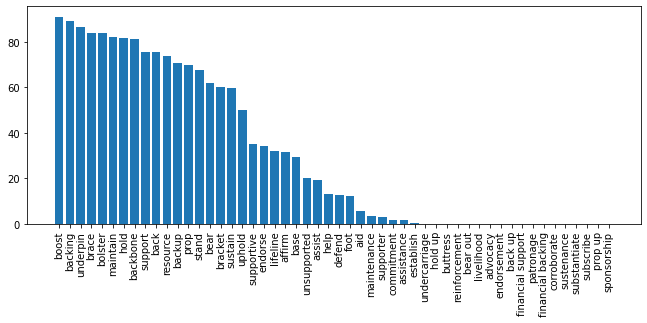

In [32]:
# plot percentages for all seed words
sorted_percentage_metaphoric_sw=dict(sorted(percentage_metaphoric_sw.items(), key=lambda item: item[1], reverse=True))
keys = sorted_percentage_metaphoric_sw.keys()
values = sorted_percentage_metaphoric_sw.values()

plt.bar(keys, values)
plt.rcParams["figure.figsize"] = (11,4)
plt.xticks(rotation=90);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


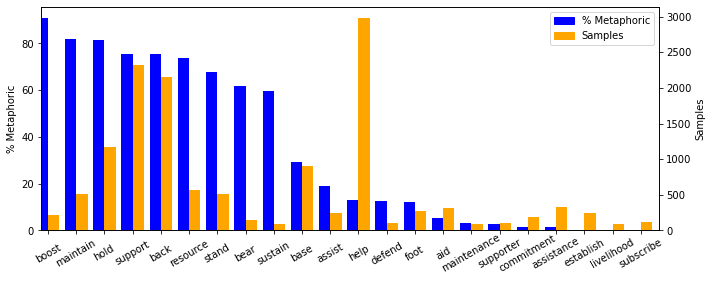

In [33]:
# compute frequencies for a grouped bar char
frequency = []
for k in sorted_percentage_metaphoric_sw: frequency.append(len(metaphor_annotated_dfs[k]))
labels = list(keys)
metaphoric_percentage = list(values)

fig = plt.figure(figsize=(10,4)) # Create matplotlib figure

# create df from which it is easy to plot
zipped = list(zip(labels, metaphoric_percentage, frequency))
df_for_plot = pd.DataFrame(zipped, columns=["Label",'Metaphoric', 'Frequency'])

df_for_plot = df_for_plot.loc[df_for_plot['Frequency'] >= 75]

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

colors = {'% Metaphoric':'blue', 'Samples':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles, labels)

width = 0.4

df_for_plot.Metaphoric.plot(kind='bar', color='blue', ax=ax, width=width, position=1)
df_for_plot.Frequency.plot(kind='bar', color='orange', ax=ax2, width=width, position=0)

ax.set_ylabel('% Metaphoric')
ax2.set_ylabel('Samples')

ax.set_xticklabels(labels=list(df_for_plot.Label),rotation=30, ha='center', va="center", position=(0,-0.07)); #ha="right"

plt.tight_layout()
fig.savefig("metaphor_stats.png")
# export as eps
fig.savefig("metaphor_stats.eps", format="eps")


# Dependency Parsing Analysis

In [ ]:
dep_res_l=list(df_all_annotated[df_all_annotated["Metaphoric_Seed"]=="literal"]["STANZA_POS_DEPS"])
c_l=Counter(dep_res_l)

Counter(dep_res_l).most_common()

In [ ]:
dep_res_m=list(df_all_annotated[df_all_annotated["Metaphoric_Seed"]=="metaphoric"]["STANZA_POS_DEPS"])
c_m=Counter(dep_res_m)

Counter(dep_res_m).most_common()

In [39]:
# merge for plotting lib
c_both={}
all_keys=set(c_m.keys()).union(set(c_l.keys()))
for k in all_keys:
    c_both[k]={"literal":0, "metaphoric":0}
    if k in c_m:
        c_both[k]["metaphoric"]=c_m[k]
    if k in c_l:
        c_both[k]["literal"]=c_l[k]

<AxesSubplot:>

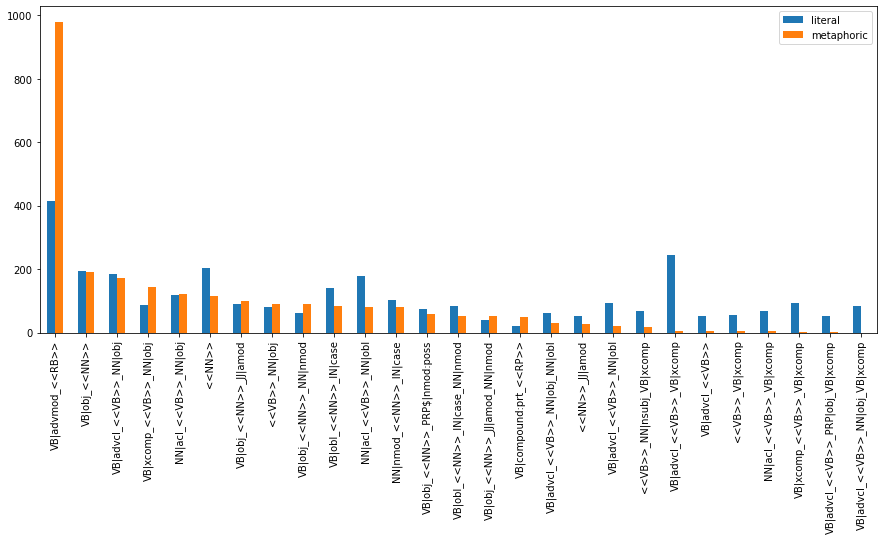

In [45]:
# make copy of df_all_annotated
df_all_annotated_merged=df_all_annotated.copy()
# rename values in STANZA_POS_DEPS column (VBZ and VBN to VB)
df_all_annotated_merged["STANZA_POS_DEPS"]=df_all_annotated_merged["STANZA_POS_DEPS"].replace({"VBZ":"VB", "VBN":"VB", "VBG":"VB", "VBD":"VB", "VBP":"VB", "NNS":"NN"}, regex=True)
dep_res_l=list(df_all_annotated_merged[df_all_annotated_merged["Metaphoric_Seed"]=="literal"]["STANZA_POS_DEPS"])
c_l=Counter(dep_res_l)
dep_res_m=list(df_all_annotated_merged[df_all_annotated_merged["Metaphoric_Seed"]=="metaphoric"]["STANZA_POS_DEPS"])
c_m=Counter(dep_res_m)

# merge for plotting lib
c_both={}
all_keys=set(c_m.keys()).union(set(c_l.keys()))
for k in all_keys:
    c_both[k]={"literal":0, "metaphoric":0}
    if k in c_m:
        c_both[k]["metaphoric"]=c_m[k]
    if k in c_l:
        c_both[k]["literal"]=c_l[k]

df_plot = pd.DataFrame.from_dict(c_both, orient="index")
df_plot=df_plot.sort_values(by="metaphoric", ascending=False)
cutoff=50
df_plot = df_plot[(df_plot['literal'] >= cutoff) |(df_plot['metaphoric'] >= cutoff)]
#fig = plt.figure(figsize=(10,4)) # Create matplotlib figure
plt.rcParams["figure.figsize"] = (15,6)
df_plot.plot(kind="bar")


In [46]:
# count metaphoric dependency constructions per seed-word (max 1 per seed-word)
dep_res_dict={}
dep_res_dict_count={}
# add all possible stanza_pos_deps to dep_res_dict
for k in df_all_annotated_merged["STANZA_POS_DEPS"].unique():
    dep_res_dict[k]=[]
    dep_res_dict_count[k]=0
# count
groups=df_all_annotated_merged[df_all_annotated_merged["Metaphoric_Seed"]=="metaphoric"].groupby("SEED_WORD")
for g in groups:
    for k in g[1]["STANZA_POS_DEPS"].unique():
        dep_res_dict[k].append(g[0])
        dep_res_dict_count[k]+=1

19


<AxesSubplot:>

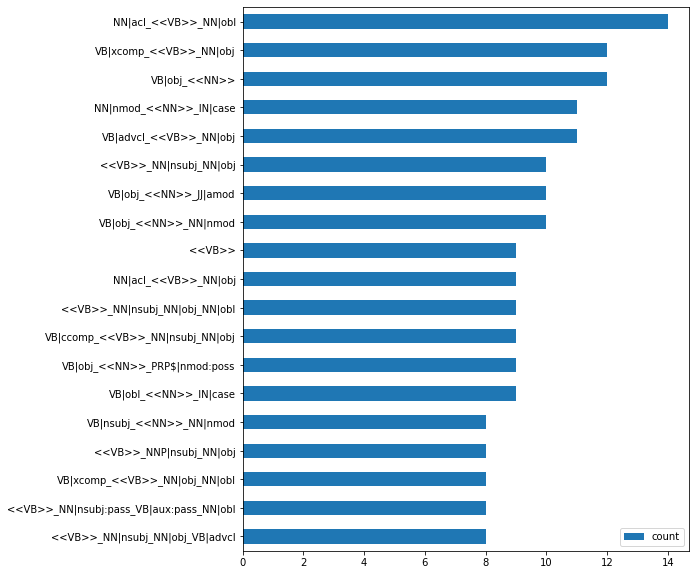

In [48]:
# plot bar chart of dep_res_dict_count
df_plot = pd.DataFrame.from_dict(dep_res_dict_count, orient="index", columns=["count"])
df_plot=df_plot[df_plot["count"]>7].sort_values(by="count", ascending=True)
plt.rcParams["figure.figsize"] = (8,10)
print(len(df_plot))
# plot bar chart horizontal
df_plot.plot(kind="barh")


103


,Pattern,count
330,NN|nsubj_<<NN>>_NN|nmod,4
335,VB|obj_<<NN>>_JJ|amod_JJ|amod,5
345,VB|obl_<<NN>>_IN|case_PRP$|nmod:poss,6
347,VB|obl_<<NN>>_IN|case_NN|nmod,6
348,VB|obj_<<NN>>_VB|acl:relcl,6
350,VB|obj_<<NN>>_JJ|amod_NN|nmod,6
352,NN|nmod_<<NN>>_IN|case_NN|nmod,6
353,VB|obl_<<NN>>_IN|case_JJ|amod_NN|nmod,6
357,<<NN>>_NN|nmod,6
361,<<NN>>,6


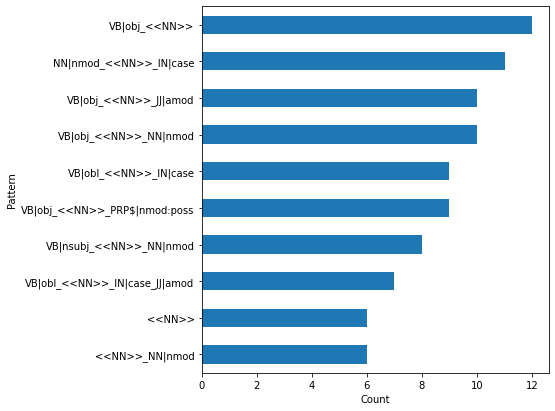

In [49]:
# plot bar chart of dep_res_dict_count
df_plot = pd.DataFrame.from_dict(dep_res_dict_count, orient="index", columns=["count"])
df_plot=df_plot[df_plot["count"]>1].sort_values(by="count", ascending=True).reset_index()
df_plot=df_plot[df_plot["index"].str.contains("<<NN>>")]
plt.rcParams["figure.figsize"] = (8,6)
print(len(df_plot))
# df plot rename index column to Pattern
df_plot.rename(columns={"index":"Pattern"}, inplace=True)
# plot bar chart horizontal
df_plot[-10:].plot(kind="barh", x="Pattern", y="count")
# increase font size of plot
plt.rcParams.update({'font.size': 16})
# plot remove legend
plt.legend().remove()
# plot add x-label
plt.xlabel("Count")
# save plot
plt.tight_layout()
plt.savefig("dep_stats_Nouns.png")
df_plot[-18:]



284


,Pattern,count
364,<<VB>>_NNP|nsubj_RB|advmod_NN|obj,6
365,NN|acl:relcl_<<VB>>_WDT|nsubj_NN|obj,7
366,NN|amod_<<VB>>,7
367,<<VB>>_NN|obj,7
368,VB|ccomp_<<VB>>_NNP|nsubj_NN|obj,7
369,VB|advcl_<<VB>>_PRP|nsubj_NN|obj,7
370,<<VB>>_NN|nsubj_RB|advmod_NN|obj,7
372,VB|xcomp_<<VB>>_NN|obl,7
373,<<VB>>_NN|nsubj:pass_VB|aux:pass_NN|obl,8
375,<<VB>>_NN|nsubj_NN|obj_VB|advcl,8


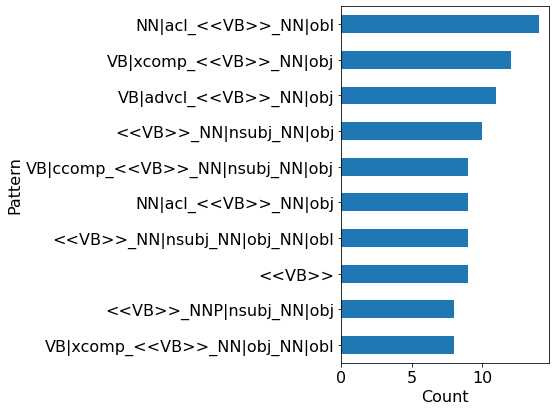

In [50]:
# plot bar chart of dep_res_dict_count
df_plot = pd.DataFrame.from_dict(dep_res_dict_count, orient="index", columns=["count"])
df_plot=df_plot[df_plot["count"]>1].sort_values(by="count", ascending=True).reset_index()
df_plot=df_plot[df_plot["index"].str.contains("<<VB>>")]
plt.rcParams["figure.figsize"] = (8,6)
print(len(df_plot))
df_plot.rename(columns={"index":"Pattern"}, inplace=True)
# plot bar chart horizontal
df_plot[-10:].plot(kind="barh", x="Pattern", y="count")
# increase font size of plot
plt.rcParams.update({'font.size': 16})
# plot remove legend
plt.legend().remove()
# plot add x-label
plt.xlabel("Count")
plt.tight_layout()
plt.savefig("dep_stats_Verbs.png")
df_plot[-20:]


179


,Pattern,count
1398,NN|amod_<<RB>>,1
1400,NN|advmod_<<RB>>_NNP|obl,1
1402,JJ|advcl_<<RB>>_VB|cop_NN|obl,1
1404,<<RB>>_RB|advmod_PRP|nsubj_VB|cop_RB|advmod_VB...,1
1405,VB|advmod_<<RB>>_RB|advmod_NNP|obl,1
1406,NNP|advmod_<<RB>>_NN|obl,1
1407,<<RB>>_NNP|obl_NN|nsubj_VB|cop_NN|obl_VB|advcl,1
1410,VB|ccomp_<<RB>>_VB|advcl_NN|nsubj_VB|cop_IN|obl,1
1986,<<JJ>>,3
2013,NN|amod_<<JJ>>,3


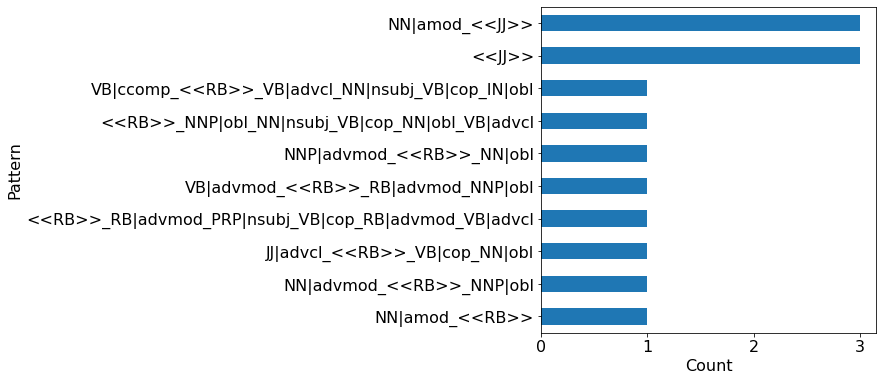

In [51]:
# plot bar chart of dep_res_dict_count
df_plot = pd.DataFrame.from_dict(dep_res_dict_count, orient="index", columns=["count"])
df_plot=df_plot[df_plot["count"]>0].sort_values(by="count", ascending=True).reset_index()
df_plot=df_plot[df_plot["index"].str.contains("<<JJ>>|<<RB>>|<<JJR>>|<<JJS>>|<<RBR>>|<<RBS>>")]
plt.rcParams["figure.figsize"] = (6,6)
print(len(df_plot))
df_plot.rename(columns={"index":"Pattern"}, inplace=True)
# plot bar chart horizontal
df_plot[-10:].plot(kind="barh", x="Pattern", y="count")
# increase font size of plot
plt.rcParams.update({'font.size': 16})
# plot remove legend
plt.legend().remove()
# plot add x-label
plt.xlabel("Count")
plt.tight_layout()
plt.savefig("dep_stats_Other.png")
df_plot[-10:]



# Clustering

## Cluster "support"

In [20]:
# define sentences that are being clustered
sentences_for_clustering = metaphor_annotated_dfs["support"]["ORIGINAL_SENTENCE"].tolist()

In [21]:
len(sentences_for_clustering)

2317

In [ ]:
# load clustering model from BERTopic library and compute clusters
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True) 
topics, probs = topic_model.fit_transform(sentences_for_clustering)

Batches: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
2022-05-08 11:34:57,966 - BERTopic - Transformed documents to Embeddings
2022-05-08 11:35:05,795 - BERTopic - Reduced dimensionality with UMAP
2022-05-08 11:35:06,008 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
# print the 5 clusters with most members. Topic -1 contains the outliers that usually should be ignored 
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,1034,-1_the_and_to_support
1,0,193,0_covid19_the_of_and
2,1,125,1_care_children_to_child
3,2,92,2_health_the_of_and
4,3,83,3_journalism_you_our_please


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
# prepare clusters for saving in txt file
list_of_topics=[]
topic_names=list(topic_model.get_topic_info()["Name"])[1:]
for i in range(len(topic_model.get_topic_info())-1):
    list_of_topics.append(topic_model.get_representative_docs(i))  
# save list_of_topics to text file
with open("clusters_support.txt", "w") as f:
    for i in range(len(list_of_topics)):
        f.write(topic_names[i]+"\n")
        for j in list_of_topics[i]:
            f.write("---"+j+"\n")
        f.write("\n")
f.close()
        

In [ ]:
# find topics related to journalism
similar_topics, similarity = topic_model.find_topics("journalism", top_n=5); similar_topics

[1, 17, 7, 27, 28]

In [ ]:
topic_model.get_topic(1)

[('journalism', 0.09721916678003913),
 ('you', 0.06894064070838037),
 ('please', 0.05475170391966732),
 ('local', 0.0515731381805162),
 ('consider', 0.049863571450366725),
 ('subscribing', 0.049553665305409195),
 ('our', 0.04779913544453664),
 ('press', 0.043492150366636596),
 ('news', 0.03861371383498026),
 ('subscribe', 0.03433260684853821)]

In [ ]:
topic_model.get_representative_docs(4)

['Third , society is showing its @ @ @ @ @ @ @ @ @ @ up digital platforms to raise funds , such as Covid-19 pandemic fund by MERCY and FV Covid-19 support fund . ',
 'A GoFundMe page that was opened Thursday to support his family showed Ernesto in a white suit at church . ',
 'PEOPLE has partnered with GoFundMe to raise money for the COVID-19 Relief Fund , a GoFundMe.org fundraiser to support everything from frontline responders to families in need @ @ @ @ @ @ @ @ @ @ information or to donate , click here . ']

Reduce Number of Clusters

In [ ]:
# after investigating the results we can also reduce the topics
new_topics, new_probs = topic_model.reduce_topics(sentences_for_clustering, topics, probs, nr_topics=15)

2022-04-18 23:30:30,227 - BERTopic - Reduced number of topics from 30 to 16


In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

## Cluster "help"

In [ ]:
# define sentences that are being clustered
sentences_for_clustering = metaphor_annotated_dfs["help"]["ORIGINAL_SENTENCE"].tolist()
len(sentences_for_clustering)

2988

In [ ]:
# load clustering model from BERTopic library and compute clusters
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True) 
topics, probs = topic_model.fit_transform(sentences_for_clustering)

Batches: 100%|██████████| 94/94 [01:34<00:00,  1.01s/it]
2022-05-08 11:44:26,906 - BERTopic - Transformed documents to Embeddings
2022-05-08 11:44:36,942 - BERTopic - Reduced dimensionality with UMAP
2022-05-08 11:44:37,265 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
# print the 5 clusters with most members. Topic -1 contains the outliers that usually should be ignored 
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,1546,-1_the_to_and_help
1,0,304,0_the_of_coronavirus_patients
2,1,98,1_we_it_us_to
3,2,70,2_journalism_us_news_our
4,3,55,3_masks_face_mask_wearing


In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
# prepare clusters for saving in txt file
list_of_topics=[]
topic_names=list(topic_model.get_topic_info()["Name"])[1:]
for i in range(len(topic_model.get_topic_info())-1):
    list_of_topics.append(topic_model.get_representative_docs(i))  
# save list_of_topics to text file
with open("clusters_help.txt", "w") as f:
    for i in range(len(list_of_topics)):
        f.write(topic_names[i]+"\n")
        for j in list_of_topics[i]:
            f.write("---"+j+"\n")
        f.write("\n")
f.close()
        

## Cluster "hold"

In [22]:
# define sentences that are being clustered
sentences_for_clustering = metaphor_annotated_dfs["hold"]["ORIGINAL_SENTENCE"].tolist()
len(sentences_for_clustering)

1169

In [ ]:
# load clustering model from BERTopic library and compute clusters
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True) 
topics, probs = topic_model.fit_transform(sentences_for_clustering)

In [182]:
# print the 5 clusters with most members. Topic -1 contains the outliers that usually should be ignored 
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,332,-1_the_to_in_and
1,0,213,0_the_to_of_in
2,1,169,1_the_of_in_hold
3,2,80,2_we_hold_you_and
4,3,65,3_school_classes_will_the


In [183]:
topic_model.visualize_topics()

In [184]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [185]:
# prepare clusters for saving in txt file
list_of_topics=[]
topic_names=list(topic_model.get_topic_info()["Name"])[1:]
for i in range(len(topic_model.get_topic_info())-1):
    list_of_topics.append(topic_model.get_representative_docs(i))  
# save list_of_topics to text file
with open("clusters_hold.txt", "w") as f:
    for i in range(len(list_of_topics)):
        f.write(topic_names[i]+"\n")
        for j in list_of_topics[i]:
            f.write("---"+j+"\n")
        f.write("\n")
f.close()
        